# Simple classification with pytorch

## Data processing

### Create a csv file 

In [1]:
import os
import glob
import yaml
import pandas as pd

def make_csv_path(excluded_labels=None):
    list_images = glob.glob('../data/raw/**/*.jpg', recursive=True)
    df = pd.DataFrame({'path': list_images})
    df['label'] = df['path'].apply(lambda x:os.path.basename(os.path.dirname(x)))
    if excluded_labels is not None:
        df = df[~df['label'].isin(excluded_labels)]
        print('Csv file constituted with {nrows} images, representing {nclasses} classes, excluding {exclusion}'.format(
        nrows=df.shape[0],
        nclasses=len(df['label'].unique()),
        exclusion= ','.join(excluded_labels)
        ))
    else:
        print('Csv file constituted with {nrows} images, representing the {nclasses} classes'.format(
            nrows=df.shape[0],
            nclasses=len(df['label'].unique())
        ))
    
    # Converting classes to number 
    labels = df['label'].unique()
    labels.sort()
    labels_map = {label:i for i, label in enumerate(labels)}
    df['y'] = df['label'].map(labels_map)

    labels_map_save = {i:label for i, label in enumerate(labels)}
    # Saving the map numbers -> label
    with open("../data/processed/labels_map.yaml", "w") as outfile:
        yaml.dump(labels_map_save, outfile)

    df.to_csv('../data/interim/filepath.csv', index=False)

make_csv_path(excluded_labels=['Corals', 'Crabs'])

Csv file constituted with 10701 images, representing 17 classes, excluding Corals,Crabs


### Creating a Custom Dataset class for the files 

In [29]:
# Modules

import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        filepath_df = pd.read_csv(annotations_file)
        self.img_labels = filepath_df['y']
        self.img_dir = filepath_df['path']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


transformf = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(256, 256)),
    T.ToTensor()
])

dataset = CustomImageDataset(annotations_file='../data/interim/filepath.csv', transform=transformf)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)



In [98]:
def get_mean_and_std(loader):
    mean = 0. 
    std = 0. 
    total_images_count = 0

    for images,_ in loader:
        image_count_batch = images.size(0)
        images = images.view(image_count_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_batch
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std
mean, std = get_mean_and_std(dataloader)

dict_mean_std = {'mean': mean.tolist(),
'std': std.tolist()}

print(dict_mean_std)

with open("../data/processed/image_mean_std.yaml", "w") as outfile:
    yaml.dump(dict_mean_std, outfile)

{'mean': [0.30578911304473877, 0.4046444892883301, 0.42739754915237427], 'std': [0.17910879850387573, 0.18213877081871033, 0.18060176074504852]}


### Plot some images for verification

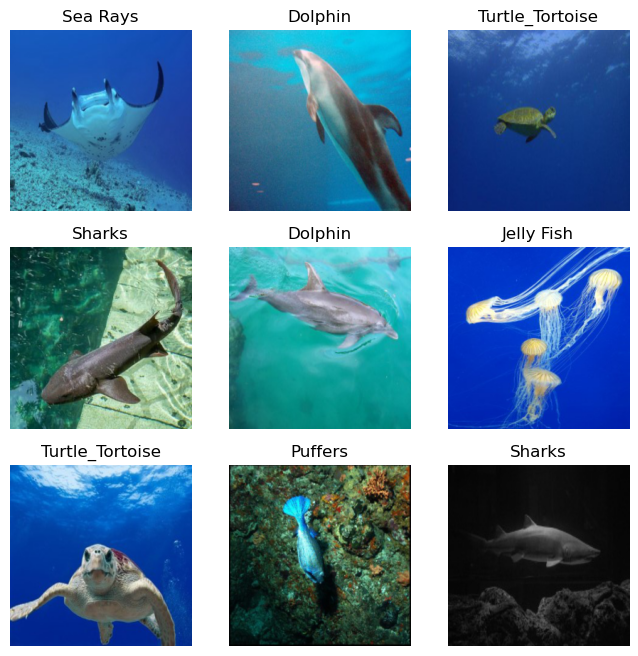

In [35]:
# Modules
import torch
import matplotlib.pyplot as plt 

# Scripts
label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation

+ Track the files with dvc 
+ Data augmentation parameters for training data, test data ? 

In [36]:
# Modules
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Script

def split_dataset(annotations_file, output_folder, test_split=0.2, val_split=0.2, random_seed=99):
    dataset = pd.read_csv(annotations_file)
    train, test = train_test_split(dataset, stratify=dataset['label'], test_size=test_split, random_state=random_seed)
    train, val = train_test_split(train, stratify=train['label'], test_size=val_split, random_state=random_seed)
    train.to_csv(os.path.join(output_folder, 'train.csv'), index=False)
    train.to_csv(os.path.join(output_folder, 'val.csv'), index=False)
    test.to_csv(os.path.join(output_folder, 'test.csv'), index=False)


split_dataset(annotations_file='../data/interim/filepath.csv', output_folder='../data/processed', val_split=0.2, random_seed=99)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


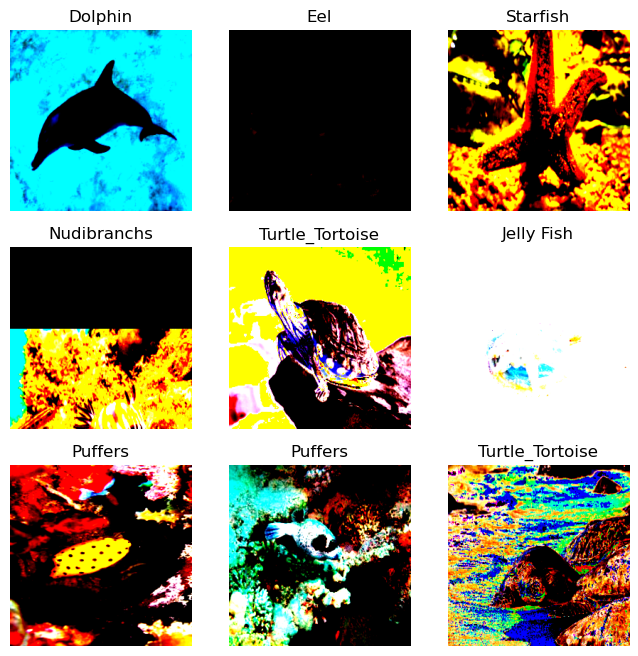

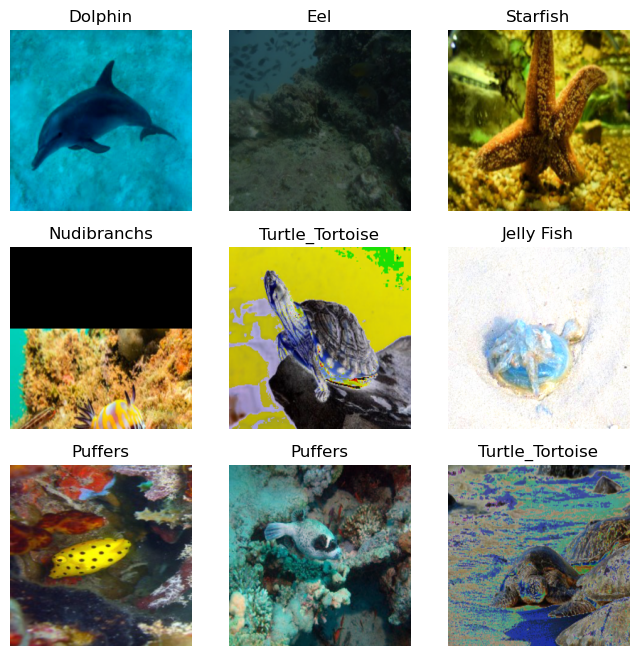

In [110]:
# Modules
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Dependencies
mean_std = yaml.safe_load(open('../data/processed/image_mean_std.yaml'))

# Parameters
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]

# Scripts 
train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=(256, 256)),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_T=T.Compose([
    T.ToPILImage(),
    T.Resize(size=(227,227)),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))

denorm = T.Normalize(
    mean=[-m / s for m, s in zip(mean_std['mean'], mean_std['std'])],
    std=[1.0 / s for s in mean_std['std']])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(denorm(img).permute(1, 2, 0))
plt.show()


## Training the network

+ Training depending on hyperparameters
    - learning rate
    - activation function ?
    - filters
    - dropout rate
+ Save the model
+ Monitoring 
    - parameters
    - training metrics (loss, time)


In [100]:
import torch.nn as nn
class VGG16(nn.Module):
    def __init__(self, num_classes=10, filter_bottom_layer=32, neurons_flat_layers=4096, dropout_rate=0.5,):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, filter_bottom_layer, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer, filter_bottom_layer, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer, filter_bottom_layer*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*2, filter_bottom_layer*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*2, filter_bottom_layer*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*4),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*4, filter_bottom_layer*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*4),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*4, filter_bottom_layer*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*4, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*8, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*8, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*8, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*8, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(filter_bottom_layer*8, filter_bottom_layer*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filter_bottom_layer*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(7*7*filter_bottom_layer*8, neurons_flat_layers),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(neurons_flat_layers, neurons_flat_layers),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(neurons_flat_layers, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [113]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

num_classes = len(label_map)
num_epochs = 5
batch_size = 16
learning_rate = 0.01

model = VGG16(num_classes, filter_bottom_layer=8, neurons_flat_layers=512, dropout_rate=0.2).to(device)

# print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  



train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=(227,227)),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Train the model
total_step = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total)) 

Using device: cuda

Epoch [1/5], Step [428/428], Loss: 2.8360
Accuracy of the network on the 6848 validation images: 24.138434579439252 %
Epoch [2/5], Step [428/428], Loss: 2.6383
Accuracy of the network on the 6848 validation images: 24.810163551401867 %
Epoch [3/5], Step [428/428], Loss: 2.4160
Accuracy of the network on the 6848 validation images: 26.591705607476637 %
Epoch [4/5], Step [428/428], Loss: 2.4671
Accuracy of the network on the 6848 validation images: 29.702102803738317 %
Epoch [5/5], Step [428/428], Loss: 1.7942
Accuracy of the network on the 6848 validation images: 29.191004672897197 %


In [114]:
test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))   

Accuracy of the network on the 2141 test images: 29.659037832788417 %


## Predict and evaluate on test set